In [2]:
import os
# check if session has spark
os.listdir()

['.config',
 'drive',
 'spark-3.5.1-bin-hadoop3.tgz',
 'spark-3.5.1-bin-hadoop3',
 'sample_data']

In [2]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz

!pip install -q findspark
!pip install pyspark

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,922 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://archive.ubuntu.com/ubuntu

In [3]:
# one time thing
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# This will prompt for authorization
# it may require you to install google drive desktop

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create shortcut to shared folder to access data

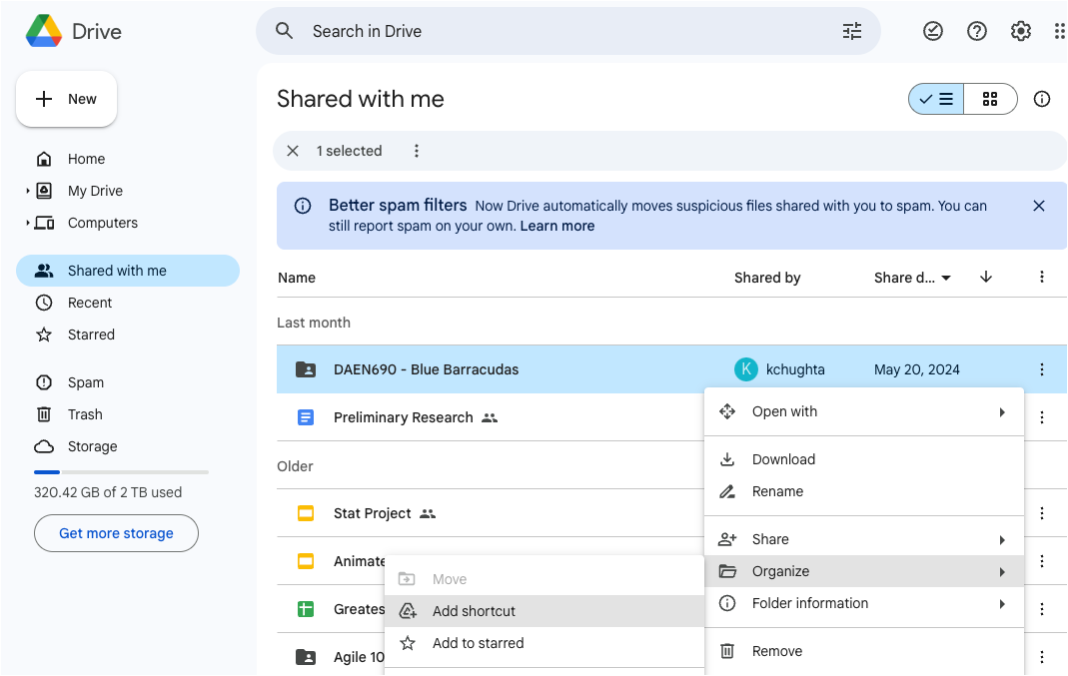

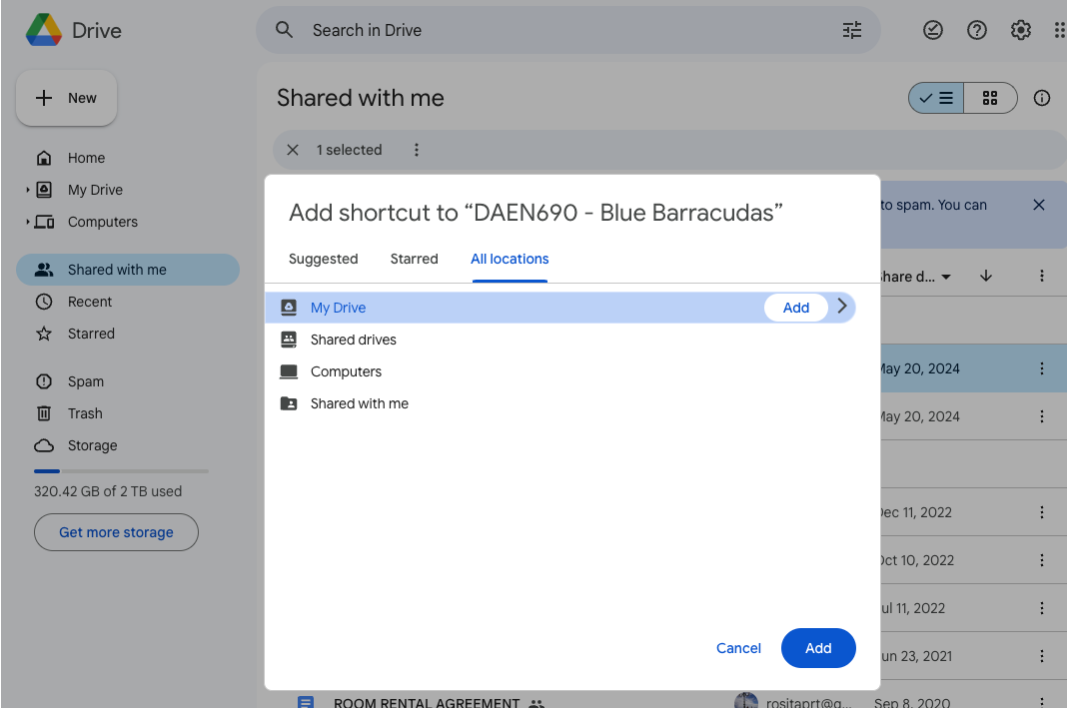

In [3]:
# Change directory to the shared folder
%cd /content/drive/MyDrive/DAEN690\ \-\ Blue Barracudas


/content/drive/.shortcut-targets-by-id/1rBkccVnDKza8090u7Fv4dXibam3Bc9k3/DAEN690 - Blue Barracudas


In [4]:
# Set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"
# Packages
import os
import pandas as pd
# Start a Spark session
import findspark
findspark.init()

# Create a SparkSession
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
#sc = SparkContext.getOrCreate()
spark = (
    SparkSession.builder.appName("MyApp")
    .config("spark.driver.memory", "12g") #Change based on your system's available memory
    .config("spark.executor.memory", "12g")
    .getOrCreate()
)
spark.sparkContext.setCheckpointDir("Data/spark_checkpoint")

In [5]:
#os.chdir('/content/drive/')
os.listdir('Data')

['gmu_dom_firstscan_20240501.zip',
 'ELFS test file.txt',
 'sample.csv',
 'gmu_dom_firstscan_20240502.zip',
 'gmu_dom_firstscan_20240503.zip',
 'd0502.zip',
 'd0501.zip',
 'd0503.zip',
 'sample.gsheet',
 'Working-df50-50.csv',
 'Data_Dictionary.xlsx',
 'intercept_list_MIDs_cleansed.xlsx',
 'usps_0502.parquet',
 'usps_0501.parquet',
 'usps_0503.parquet',
 'spark_checkpoint']

In [6]:
# Read parquet file to DF
folder1 = "/content/drive/MyDrive/DAEN690 - Blue Barracudas/Data/usps_0501.parquet"
folder2 = "/content/drive/MyDrive/DAEN690 - Blue Barracudas/Data/usps_0502.parquet"
folder3 = "/content/drive/MyDrive/DAEN690 - Blue Barracudas/Data/usps_0503.parquet"
parc_folders = [folder1,folder2,folder3]
df = spark.read.parquet(*parc_folders)


In [7]:
#Cleaning -----
# data from 0503 read ServiceType code as int so it removed 0s to the left;adding those back
df = df.withColumn('ServiceTypeCode', lpad(col('ServiceTypeCode'), 3, '0'))

# Get the list of columns that contain 'zipcode'
zipcode_columns = [col for col in df.columns if 'zipcode' in col]

# Define a function to add leading zeros
def add_leading_zeros(col):
    return lpad(col, 5, '0')

# Apply the function to all zipcode columns
for col in zipcode_columns:
    df = df.withColumn(col, add_leading_zeros(df[col]))

# recode CMRA flag
df = df.withColumn(
    'CRID_cmra_flag',
    when(df['CRID_cmra_flag'] == 'Y', True)
    .when(df['CRID_cmra_flag'].isin(['N', 'X']), False)
    .otherwise(None)
)

# recode delinked nulls
df = df.withColumn("delinked", when(df["delinked"].isNull(), False).otherwise(df["delinked"]))


In [8]:
# create potential fraud column
df = df.withColumn(
    "potential_fraud",
    when(df["delinked"] == True, True)
    .when(df["icr_or_manifest"] == False, True)
    .when(df["symbology_mismatch"] == True, True)
    .when(df["firstzip_startzip_diff"] == True, True)
    .otherwise(False)
)

In [11]:
total_rows = df.count()
total_rows #61,256,141

61256141

In [12]:
df.groupby('potential_fraud').count().show()

+---------------+--------+
|potential_fraud|   count|
+---------------+--------+
|           true|21918680|
|          false|39337461|
+---------------+--------+



# Incorporate intercepted mailerids

In [9]:
import pandas as pd
data = pd.read_excel("Data/intercept_list_MIDs_cleansed.xlsx")
df2_spark = spark.createDataFrame(data)

In [10]:
df = df.withColumn("intercepted_fraud", lit(False))

In [11]:
df_joined = df.join(df2_spark, df.mailerid == df2_spark.mailerid, how="leftsemi").withColumn("temp", lit(True))
df_joined = df_joined.drop("intercepted_fraud").withColumnRenamed("temp", "intercepted_fraud")
df_antijoin = df.join(df2_spark, df.mailerid == df2_spark.mailerid, how="leftanti")

In [12]:
df_labeled = df_joined.union(df_antijoin)

In [20]:
df_labeled.groupBy("intercepted_fraud").count().show()

+-----------------+--------+
|intercepted_fraud|   count|
+-----------------+--------+
|             true|   80309|
|            false|61175832|
+-----------------+--------+



In [13]:
df_labeled.rdd.getNumPartitions()

400

In [14]:
df_labeled.cache()  # Cache the DataFrame

DataFrame[ciso_primary_key: bigint, mailpieceid: string, parcelidcode: string, detailsequence: bigint, createdtimestamp: timestamp, mailerid: string, sourceid: string, ServiceTypeCode: string, applicationid: int, constructcode: string, mailclasscode: string, USPSDimensionalHeight: double, USPSDimensionalLength: double, USPSDimensionalWidth: double, customerrecordstartdate: date, delinked: boolean, MID_LAST_UPD_USERID: string, MID_LAST_UPD_DATE: date, CRID: string, CRID_cmra_flag: boolean, CRID_msp_flag: string, UBK: string, icr: int, ict_filedate: date, manifest: int, manifest_createdtimestamp: timestamp, manifestid: string, icr_or_manifest: int, spef: int, prtnrscan_createdtimestamp: timestamp, prtnrscan_eventcode: string, symbology_mismatch: int, scanned: int, firstscan_createdtimestamp: timestamp, firstscan_eventcode: int, firstscan_zipcode: string, firstscan_Longitude: double, firstscan_Latitude: double, firstscan_CITY: string, firstscan_STATECODE: string, firstscan_STATENAME: stri

In [15]:
df_labeled_10 = df_labeled.coalesce(40) # change to 40 partitions (or future csv files)
df_labeled_10.write.csv("Data/all_data")

In [16]:
df_labeled.unpersist() # free disk memory

DataFrame[ciso_primary_key: bigint, mailpieceid: string, parcelidcode: string, detailsequence: bigint, createdtimestamp: timestamp, mailerid: string, sourceid: string, ServiceTypeCode: string, applicationid: int, constructcode: string, mailclasscode: string, USPSDimensionalHeight: double, USPSDimensionalLength: double, USPSDimensionalWidth: double, customerrecordstartdate: date, delinked: boolean, MID_LAST_UPD_USERID: string, MID_LAST_UPD_DATE: date, CRID: string, CRID_cmra_flag: boolean, CRID_msp_flag: string, UBK: string, icr: int, ict_filedate: date, manifest: int, manifest_createdtimestamp: timestamp, manifestid: string, icr_or_manifest: int, spef: int, prtnrscan_createdtimestamp: timestamp, prtnrscan_eventcode: string, symbology_mismatch: int, scanned: int, firstscan_createdtimestamp: timestamp, firstscan_eventcode: int, firstscan_zipcode: string, firstscan_Longitude: double, firstscan_Latitude: double, firstscan_CITY: string, firstscan_STATECODE: string, firstscan_STATENAME: stri

In [ ]:
#subset_5perc_W= df_labeled.sample(fraction=0.05)
#subset_5perc_W = subset_5perc_W.coalesce(10)
#subset_5perc_W.write.csv("Data/subset_5perc")